<a href="https://colab.research.google.com/github/nredick/code-playground/blob/main/Annotated_Version_of_MAIS_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stone Classifier using a Sequential Convolutional Neural Network (CNN) 

The idea behind a CNN is relatively simple: it attempts to detect the desired features from image data using filters and extracting the significant features to make predictions.

Load dataset from kaggle and unzip the data.
> Upload ~/.kaggle/kaggle.json file before running



The dataset I created is stored privately on [Kaggle](https://www.kaggle.com/) so we need an authentification file (kaggle.json) to be able to access it. 

In [ ]:
# make a directory to hold the authentification file 
!mkdir ~/.kaggle

# move the auth file to the dir
!mv kaggle.json ~/.kaggle/

# change the auth file permissions so that we can use it 
!chmod 600 /root/.kaggle/kaggle.json

This dataset contains 1801 images in the train data and 259 images in the test data. 

Each of the images is categorized as either a rock, fossil, gemstone, or mineral in the file name. (e.g. fossil3848.jpeg) 

In [ ]:
# download the dataset from Kaggle and unzip it 
!kaggle datasets download -d nathalieredick/rocks-and-fossils
!unzip rocks-and-fossils.zip

In [ ]:
# imports 

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import PIL
import glob
import re
import math
from PIL import Image

In [ ]:
# set path variables to the data 

dataset_path = '/content/datasets3 copy'
classes_path = '/content/datasets3 copy/classes.csv'

# Resize the images and visualize the data 

Load images in color and display some sample images. 

In [ ]:
## read in the images

# create a list of paths to each of the train images 
image_paths = list(glob.glob(f'{dataset_path}/X_train/*.jpeg'))

# iterate through each of the images in the dataset 
for i in image_paths:
  im = Image.open(i) # open the image 
  resized = im.resize((32, 32), Image.ANTIALIAS) # resize each image to 32x32 pixels
  resized.save(i, 'JPEG', quality=300) # save the resized image

# convert the data to a np array from a list created via list comprehension 
# where str(x) becomes a label based on the name of the file, and 
# cv2.IMREAD_COLOR reads the images into an array   
X_train = np.stack([cv2.imread(str(x), cv2.IMREAD_COLOR)
                   for x in image_paths])

# create a list of paths to each of the test images and repeat the resizing & labelling process
image_paths = list(glob.glob(f'{dataset_path}/X_test/*.jpeg'))
for i in image_paths:
  im = Image.open(i)
  resized = im.resize((32, 32), Image.ANTIALIAS) 
  resized.save(i, 'JPEG', quality=300)
X_test = np.stack([cv2.imread(str(x), cv2.IMREAD_COLOR) 
                   for x in image_paths])

(32, 32, 3)


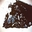

(32, 32, 3)


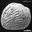

(32, 32, 3)


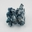

(32, 32, 3)


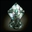

(32, 32, 3)


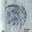

In [ ]:
## display 5 of the images to get a better idea of the data 

img_size = X_train[0].shape # set a variable for image size that we can use later 

for i in range(5):
  print(X_train[i].shape) # print the shape of the image array 
  display(PIL.Image.fromarray(X_train[i])) # display the image using the PIL module 

Each of the images now exists as a (32, 32, 3) array: 32 by 32 pixels by 3 values for RGB since our images are coloured. 

It's worth noting that the images are small and the colour is inconsistent. They are also not centered in the same ways (different margins between each sample and the edges of the image). These kinds of discrepancies can cause issues down the line when training the model, which further preprocessing of the images can attempt to rectify. 

# Image Preprocessing 

Remove unwanted noise using Gaussian blur, which is a way to remove noise from an image. Noise in image data is generally random variations of brightness or color that obscures the desired information. 

In [ ]:
# define a function to remove noise from an array of photos 
def remove_noise(dataset):
  no_noise = []
  for img in dataset:
      blur = cv2.GaussianBlur(img, (5, 5), 0)
      no_noise.append(blur)
  return no_noise # return an array of images that have been de-noised 

In [ ]:
# remove the noise from each of the train and test sets 

X_train_og = X_train
X_train = remove_noise(X_train)

X_test_og = X_test
X_test = remove_noise(X_test)

'Original'

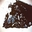

'Blurred'

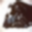

In [ ]:
# see the difference between the image before and after the Gaussian blur was applied 
display('Original', PIL.Image.fromarray(X_train_og[0]), 'Blurred', PIL.Image.fromarray(X_train[0]))

# Labelling and class identification 

In [ ]:
# get the number of classes 
classes = [re.findall('^[a-z]+', row)[0] for row in open(classes_path, 'r')]
num_classes = sum(1 for c in classes)
print('Classes: ', classes, '\nNumber of classes: ', num_classes)

Classes:  ['fossil', 'gemstone', 'mineral', 'rock'] 
 Number of classes:  4


The function 'get_labels' retrieves the image name from the filenames. 

In [ ]:
# def a func to extract the labels of the images from their filenames 
def get_labels(X):
  y = []
  for item in os.listdir(f'{dataset_path}/{X}/'):
    name = re.findall('^[a-z]+', item) # uses regex to find the word each filename beings with 
    y.append(*name) # * is a function that extracts image from a list so that we don't end up with a nested list 
  return y

# use the function to get labels from the train and test data label arrays 
y_train = get_labels('X_train')
y_test = get_labels('X_test')
print('y_train: ', y_train, '\ny_test: ', y_test)

y_train:  ['rock', 'fossil', 'mineral', 'gemstone', 'fossil', 'gemstone', 'rock', 'mineral', 'rock', 'fossil', 'mineral', 'rock', 'fossil', 'gemstone', 'rock', 'rock', 'rock', 'fossil', 'fossil', 'fossil', 'gemstone', 'rock', 'rock', 'gemstone', 'mineral', 'gemstone', 'gemstone', 'rock', 'rock', 'fossil', 'mineral', 'fossil', 'fossil', 'rock', 'mineral', 'mineral', 'fossil', 'rock', 'rock', 'gemstone', 'mineral', 'rock', 'gemstone', 'mineral', 'rock', 'rock', 'rock', 'mineral', 'gemstone', 'fossil', 'fossil', 'fossil', 'gemstone', 'mineral', 'mineral', 'gemstone', 'rock', 'mineral', 'rock', 'rock', 'mineral', 'gemstone', 'fossil', 'rock', 'fossil', 'gemstone', 'rock', 'rock', 'gemstone', 'mineral', 'rock', 'mineral', 'mineral', 'rock', 'mineral', 'fossil', 'fossil', 'rock', 'mineral', 'fossil', 'gemstone', 'gemstone', 'mineral', 'fossil', 'rock', 'gemstone', 'mineral', 'fossil', 'mineral', 'gemstone', 'mineral', 'fossil', 'fossil', 'mineral', 'rock', 'fossil', 'fossil', 'mineral', 'min

In [ ]:
# define a function to encode the classes in the datasets as ints 
def classes_to_nums():
  classes = []
  names = []
  for i, row in enumerate(open(classes_path, 'r')):
    name = re.findall('^[a-z]+', row) # regex to extract name  
    if name not in names:
      names.append(name)
      classes.append([i, *re.findall('^[a-z]+', row)])
    else: # catch bad cases eg misnamed files, etc. 
      print('classes to nums fail')
  return classes

In [ ]:
def numerical_labels(classes, labels):
  result = []
  for l in labels:
    for c in classes:
      if l == c[1]:
        result.append(c[0])
  return result

In [ ]:
# convert image data to numpy arrays 
X_train = np.array(X_train)
X_test = np.array(X_test)

# get encoded labels of each set
numerical_classes = classes_to_nums()
y_train = numerical_labels(numerical_classes, y_train)
y_test = numerical_labels(numerical_classes, y_test)
print(len(y_train))


1801


# Tensorflow imports & one-hot encoding



In [ ]:
# imports for the CNN
from __future__ import print_function
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential

Using TensorFlow backend.


One hot encoding converts labels to arrays. It is useful when labels have no relation/order/preference. In this case, only numerically encoding the labels might force the CNN to make connections between labels that do not exist. 

To counter this phenomenon, the lebels are one-hot encoded. 

For instance,  a label of 1 would become [1, 0, 0, ...] and a label of 2 would become [0, 1, 0, ...]. 

One-hot encoding is already implemented in most ML libraries. 

In [ ]:
# one hot encode data labels for train and test data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(1801, 4)
(259, 4)


# Initialize settings for the CNN model 

In [ ]:
# settings for CNN model
batch_size = 256 # the number of image samples the CNN will train on in an iteration 
epochs = 30 # the number of passes of the entire training dataset the machine learning algorithm will make 

save_dir = os.path.join(os.getcwd(), 'saved_models') # create a directory path to save the model to 
model_name = 'rocks_and_fossils.h5'

In [ ]:
# print the data, split between train and test sets:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# scale the pixel values to between 0 and 1 
X_train /= 255
X_test /= 255

num_of_test_samples = X_test.shape[0]

print('X_train shape:', X_train.shape, '\t', X_train.shape[0], 'train samples')
print('X_test shape:', X_test.shape,'\t', X_test.shape[0], 'test samples')

X_train shape: (1801, 32, 32, 3) 	 1801 train samples
X_test shape: (259, 32, 32, 3) 	 259 test samples


# Declare the sequential CNN model and add layers 

The structure of layers for a model is based on what kind of data you are trying to classify and how you want the model to classify it. As such, it's important to understand why certain layers are better for certain functions. 

This image gives a useful visual of a traditional CNN. 

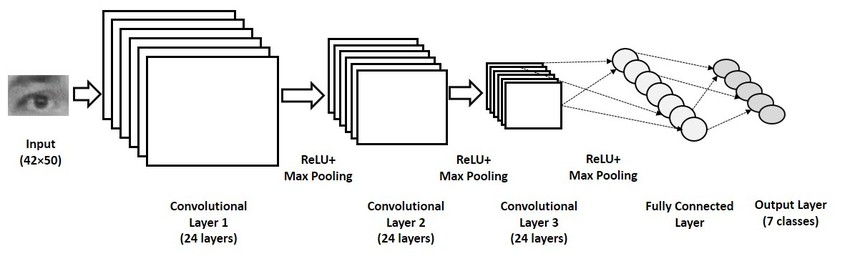

*Source: [The Most Intuitive and Easiest Guide for Convolutional Neural Network](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480#:~:text=Flattening%20is%20converting%20the%20data,called%20a%20fully%2Dconnected%20layer.)*

Conv2D Layer: 
> "A convolution is the application of a filter to an input that results in an activation. Repeated application of the same filter to an input results in a map of activations called a feature map, indicating the locations and strength of a detected feature in an input, such as an image."

*Source: [How Do Convolutional Layers Work in Deep Learning Neural Networks?](hthttps://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/tps://)*

**Activation Layer:**
> Activation functions help the network use the important information and ignore the irrelevant data points by determining which 'neurons' in the network should be fired. 
>
>A *ReLu activation function* (rectified linear activation function) is a popular choice for CNNs because it increases the non-linearity of the data, which in a CNN is an image. Images are naturally non-linear, so applying a ReLu helps the CNN better model the relationships between images and labels.
>
>A *softmax activation function* is useful for models that are attempting to categorize data into more than 2 groups (non-binary) because the softmax function assigns decimal probabilities that must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would. 

*Source: [Fundamentals of Deep Learning – Activation Functions and When to Use Them?](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/)*

*Source: [A Gentle Introduction to the Rectified Linear Unit (ReLU)](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)* 

*Source: [link text](https://)*

**MaxPooling2D Layer:**
> A pooling layer “accumulates” features from maps generated by convolving a filter over an image, in this case, the Conv2D layer. The MaxPooling layer helps reduce the size of the network to, in turn, reduce the amount of parameters and computation required during training. 

*Source: [What is Max Pooling?](https://deepai.org/machine-learning-glossary-and-terms/max-pooling)*

**Dropout Layer:** 
> Dropout is a regularization method that helps prevent over fitting in ANNs. A portion of the nodes are randomly 'dropped' from the network, in order to reduce the formation of co-dependencies between nodes. Note that they are not removed completely, just ignored during a certain pass of the network. 

*Source: [Dropout in (Deep) Machine learning](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)*

**Flatten Layer:** 
> Flattening converts the data into a 1D array for inputing it to the next layer. The flattening layer is traditionally connected to the fully connected final layer. 

*Source: [The Most Intuitive and Easiest Guide for Convolutional Neural Network(https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480#:~:text=Flattening%20is%20converting%20the%20data,called%20a%20fully%2Dconnected%20layer.)*

**Dense Layer:** 
> In short, a dense layer is used to change the dimensions of a vector. In itself, it is an 'm' dimensional vector used to perform matrix-vector multiplication on all of the inputs from the previous layer. The values in the dense matrix are parameters that can be trained and updated via backpropagation. 

*Source: [Keras Dense Layer Explained for Beginners](https://machinelearningknowledge.ai/keras-dense-layer-explained-for-beginners/*


In [ ]:
model = Sequential() # init a sequential model from the tf library; we are implementing a sequential CNN 

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=X_train.shape[1:]))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Early stopping is another commonly used regularization method to prevent the model from overfitting to the data. 

Early stopping analyzes the model's performance during each epoch and stops training the model after the error indicates that it has reached the minimum. 

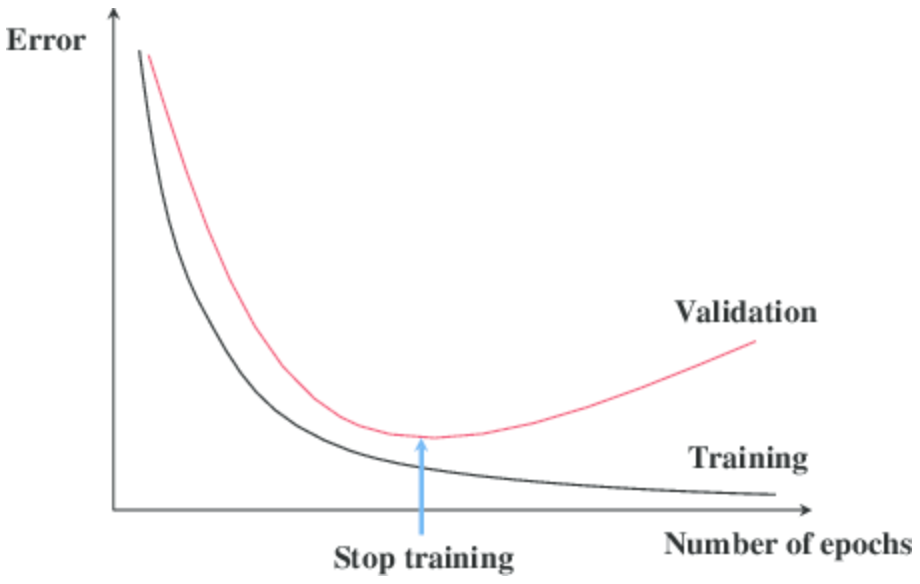

In this case, we are using early stopping to monitor loss with a patience of 5: when the loss of the model has increased for 5 epochs, then the model is saved. 

Model checkpoint is used to save the model at it's best (minimum loss). 

The array that contains the parameters for early stopping and model checkpointing is passed to the fit() function. 

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

**Loss Functions** 

Categorical cross-entropy (aka softmax loss) is a loss function that measures the performance of a classification model whose output is a probability value between 0 and 1. Because we used a softmax activation function with the fully-connected layer of the model, our classes probabilities will be between 0 and 1. 

Trains a CNN to output a probability over the n classes for each image. 

Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of 0.1 when the actual observation label is 1 would result in a high loss value.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', # RMSprop uses an adaptive learning rate instead of treating the learning rate as a hyperparameter so the learning rate changes over time
              metrics=['accuracy', 'mse']) # mse = mean squared error 

'''
model.fit is the how we call the function from the tf library 
to train the model based on the parameters that have been defined: 
- # of epochs and batch size
- layers
- callback: early stopping and model checkpoint
- loss, optimizer, and metrics from model.compile 
'''
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=1, shuffle=True, callbacks=callbacks)

Epoch 1/30
57/57 [==============================] - 4s 68ms/step - loss: 1.2573 - accuracy: 0.4814 - mse: 0.1695 - val_loss: 0.8752 - val_accuracy: 0.6757 - val_mse: 0.1205
Epoch 2/30
57/57 [==============================] - 4s 63ms/step - loss: 1.0119 - accuracy: 0.5997 - mse: 0.1380 - val_loss: 1.0567 - val_accuracy: 0.5676 - val_mse: 0.1478
Epoch 3/30
57/57 [==============================] - 4s 63ms/step - loss: 0.9605 - accuracy: 0.6408 - mse: 0.1293 - val_loss: 0.7561 - val_accuracy: 0.7066 - val_mse: 0.1060
Epoch 4/30
57/57 [==============================] - 4s 63ms/step - loss: 0.8758 - accuracy: 0.6791 - mse: 0.1168 - val_loss: 0.8055 - val_accuracy: 0.6371 - val_mse: 0.1230
Epoch 5/30
57/57 [==============================] - 4s 62ms/step - loss: 0.8814 - accuracy: 0.6952 - mse: 0.1108 - val_loss: 0.7932 - val_accuracy: 0.6448 - val_mse: 0.1125
Epoch 6/30
57/57 [==============================] - 4s 65ms/step - loss: 0.7917 - accuracy: 0.6985 - mse: 0.1069 - val_loss: 0.6348 - v

In [ ]:
# print a summary of the model training 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [ ]:
# save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print(f'Saved trained model at {model_path}')

# score trained model
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# save model as json file
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("model.h5")

Saved trained model at /content/saved_models/rocks_and_fossils.h5
9/9 [==============================] - 0s 13ms/step - loss: 0.1486 - accuracy: 0.9382 - mse: 0.0221
Test loss: 0.14863738417625427
Test accuracy: 0.9382239580154419


Sources:

[Building a CNN (1)](https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5)

[Building a CNN (2)](https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f)

[Early Stopping](https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/)

[Datagen](https://keras.io/examples/cifar10_cnn/)

[What is One Hot Encoding and How to Do It](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179)